## Thermal finite-element analysis for the BLAST CubeSat

This notebook shows how to use all modules in this repo for a reasonable preliminary on-orbit thermal analysis. 

We'll use a much more interesting (but still very simple) model of the sat. This one has six elements, one for each face of the sat. The sat's mass is evenly distributed among the elements, except the GGB tip mass is fully localized on the GGB face. The specific heat capacities still assume most of the mass is Al 6061 (which is pretty accurate, especially since most of our electronics are encased in that), except again for the tip mass, which is filled with lead shot. The long faces have solar panels on them, the GGB face exposed surfaces are entirely aluminum, and the antenna face only has the antenna's FR4 PCB exposed. Each face is connected to four adjacent faces. The conduction coefficient could definitely use some refining and I'm eyeballing the contact area, but I tried to be conservative in the hopes that internal radiation, which is not accounted for here, will act as additional effective thermal conduction in equalizing the different components of the sat.

All in all, this model should be quite accurate at reflecting the temperature range the sat's solar panels will experience. It is less accurate for internals, since the internal heat load of elecrtonic components will vary, so real components may experience temperature extremes outside of what this model shows.

In [1]:
from constants import *
from lumped_mass import *
from orbit import *
from rotation_sim import *
#from plotting import *
import plotting
import numpy as np
import scipy

## Sat model

In [2]:
def init_blast_model(
        ephem_path: str,
        R0: np.ndarray|None = None, 
        omega0: np.ndarray|None = None, 
        omega_mag: float|None = np.radians(1),
) -> tuple[list[ConnectedLumpedMass], Body, Orbit]:
    """Create lumped masses, a Body, and an Orbit to represent the BLAST CubeSat
    
    Creates an SGP4Orbit with ISS TLEs. Must specify ephem_path to point to ephemeris.

    Uses six ConnectedLumpedMasses, one for each face.

    R0 can be optionally used to specify the starting body orientation in the inertial (stationary) frame.
        Randomized if not specified.
    omega0 can be optionally used to specify the starting body angular velocity in the body (rotating) frame.
        Randomized if not specified (with magnitude equal to omega_mag, default 1 deg/s).
    """
    orbit = SGP4Orbit(
        *ISS_TLE, 
        ephem_path,
        t_tol=10
    )

    long_side_elt_dict = {
        'm': (CUBESAT_MASS-CUBESAT_TIP_MASS)/5,
        'c': AL_6061_SPEC_HEAT_CAP,
        'A_rad': 10*u.cm*20*u.cm,
        'a': SOLAR_PANEL_ABSORPTANCE,
        'e': SOLAR_PANEL_EMISSIVITY,
        'q_int': CUBESAT_POWER_CONSUMPTION/5,
        'T0': 273*u.degK,
        'store_history': True
    }

    elts = [ # long faces
        ConnectedLumpedMass(
            body_normal = np.array(normal),
            **long_side_elt_dict,
        )
    for normal in [[1,0,0], [0,1,0], [-1,0,0], [0,-1,0]]]

    elts.append(ConnectedLumpedMass( # GGB square face
        body_normal = np.array([0,0,-1]),
        m= (CUBESAT_MASS-CUBESAT_TIP_MASS)/10 + CUBESAT_TIP_MASS,
        c= PB_SPEC_HEAT_CAP,
        A_rad= 10*u.cm*10*u.cm + CUBESAT_TIP_MASS_EXT_AREA,
        a= AL_ABSORPTANCE,
        e= AL_EMISSIVITY,
        q_int= CUBESAT_POWER_CONSUMPTION/10,
        T0=273*u.degK,
        store_history = True
    ))
    elts.append(ConnectedLumpedMass( # antenna square face
        body_normal = np.array([0,0,1]),
        m= (CUBESAT_MASS-CUBESAT_TIP_MASS)/10,
        c=AL_6061_SPEC_HEAT_CAP,
        A_rad= 10*u.cm*10*u.cm,
        a= FR4_ABSORPTANCE,
        e= FR4_EMISSIVITY,
        q_int= CUBESAT_POWER_CONSUMPTION/10,
        T0=273*u.degK,
        store_history = True
    ))

    for i,long_face in enumerate(elts[:4]):
        # Each long face connects to both of the square faces
        long_face.connect(elts[4], K = AL_HEAT_CONDUCTIVITY * 2*u.cm * 10*u.cm)
        long_face.connect(elts[5], K = AL_HEAT_CONDUCTIVITY * 2*u.cm * 10*u.cm)
        # Each long face connects to two adjacent long faces,
        # but since connect is bidirectional, only call it on the next face
        long_face.connect(elts[(i+1)%4], K = AL_HEAT_CONDUCTIVITY * 2*u.cm * 20*u.cm)

    if omega0 is None:
        random_omega = np.random.normal(size=3)
        omega0 = random_omega * omega_mag/np.linalg.norm(random_omega) 
    if R0 is None:
        random_bodyR = scipy.stats.special_ortho_group.rvs(3)
        R0 = random_bodyR
    body = Body(
        np.diag([CUBESAT_ROTI_XY.to(u.kg*u.m**2).magnitude, CUBESAT_ROTI_XY.to(u.kg*u.m**2).magnitude, CUBESAT_ROTI_Z.to(u.kg*u.m**2).magnitude]),
        R0_inertial= R0,
        omega0_body=omega0
    )

    return elts, body, orbit

## Propagator

In [3]:
def eval_funct(t: float, state_vec: np.ndarray, t0: pd.Timestamp, elts: list[LumpedMass], body: Body, orbit: Orbit) -> np.ndarray:
    """Derivative function
    
    State vector convention: shape (9 + 3 + len(Body.elts)) in the order:
        R, omega, T

    Calculates Tdot for Body.elts using temperatures from y and orbital state from orbit,
    and calculates rotation matrix and angular velocity vector derivatives for Body.
    """ 
    body_R = state_vec[:9].reshape(3,3)
    body_omega = state_vec[9:12]
    T_vec = state_vec[12:]

    orbit.set_input(t0+pd.Timedelta(seconds=t))
    q_solar_normal, q_earth_normal = orbit.get_sun_earth_normal_power()
    r_earth, r_sun = orbit.get_earth_sun_vecs()

    body.set_input(body_R, body_omega)
    Rdot, omegadot = body.get_derivs()

    for T, elt in zip(T_vec, elts):
        elt.set_input(t, T, r_earth=r_earth, r_sun=r_sun, body_R=body_R, q_solar_normal=q_solar_normal, q_earth_normal=q_earth_normal)
    Tdot_vec = np.array([elt.find_Tdot() for elt in elts])

    return np.concat([Rdot.flatten(), omegadot, Tdot_vec])

def propagate_thermal_fem(
    elts: list[LumpedMass], body: Body, orbit: Orbit, 
    t_start: pd.Timestamp, duration: pd.Timedelta, t_step: pd.Timedelta,
    **kwargs
):
    y0 = np.concatenate((body.R.flatten(), body.omega, np.array([elt.T for elt in elts])))
    return scipy.integrate.solve_ivp(
        eval_funct, 
        (0, duration.total_seconds()), 
        y0, 
        args=(t_start, elts, body, orbit),
        t_eval = np.arange(0,duration.total_seconds(),t_step.total_seconds()),
        **kwargs
    )

# Below is an alternative propagator function, which interrupts solve_ivp
# periodically to reorthonormalize the body rotation matrix.
# You may try this if rotation kinematics look fishy.

# def propagate_thermal_fem(
#         elts: list[LumpedMass], body: Body, orbit: Orbit, 
#         t_start: pd.Timestamp, duration: pd.Timedelta, t_step: pd.Timedelta,
#         **kwargs
# ):
#     """Propagate FEM with attitude, orbital position, and temperature.
    
#     The numerical itegrator will be interrupted every t_step
#     to reorthonormalize the body rotation martix
#     and print a rudimentary progress log (since solve_ivp doesn't offer callbacks).
#     """
#     ts = []; ys = []; total_nfev = 0
#     t= 0 # relative to start_t in sec
#     y = np.concatenate((body.R.flatten(), body.omega, np.array([elt.T for elt in elts])))

#     while t < duration.total_seconds():
#         res = scipy.integrate.solve_ivp(
#             eval_funct, 
#             (t, t+t_step.total_seconds()), 
#             y, 
#             args=(t_start, body, orbit),
#             **kwargs
#         )
#         assert res.status == 0
#         ts.extend(res.t); ys.extend([res.y[:,i] for i in range(res.y.shape[1])]); total_nfev += res.nfev
        
#         # Reorthonormalize rotation matrix
#         body_R = res.y[:9, -1].reshape(3,3)
#         body_R_corrected = reorthonormalize(body_R)

#         t= res.t[-1]
#         y = np.concatenate((body_R_corrected.flatten(), res.y[9:, -1]))

#         if np.isclose(t % 100, 0): 
#             print(f"{t} / {duration.total_seconds()}, nfev: {total_nfev}")
#             total_nfev = 0

#     return ts, ys

In [4]:
elts, body, orbit = init_blast_model(
    'excerpt_de440.bsp',
    R0=np.eye(3), omega0=np.array([0,0,np.radians(5)]),
    )
elt_names = [f"SP{i}" for i in range(1, 5)] + ["GGB", "Ant"]

Let's run a simple propagation for 1 minute with 1 second time steps. This will use the ISS TLEs saved in `constants.py`, propagated to the current time (if you haven't updated the ISS TLEs, the resulting position will probably be quite a bit off the actual current ISS position, since TLEs stop accurately predicting after a couple weeks).

In [5]:
sol = propagate_thermal_fem(
    elts, body, orbit,
    pd.Timestamp.now(tz='UTC'), pd.Timedelta(minutes=1), pd.Timedelta(seconds=1)
)

As a first sanity check, let's sum all the heat conductance flows - this should come out to zero (or within floating-point error thereof).

In [12]:
q_cond_net_tot = pd.Series(data=0, index=elts[0].get_history(sol.t).index)
for elt in elts:
    q_cond_net_tot += elt.get_history(sol.t).q_cond_net
q_cond_net_tot.abs().max()

np.float64(1.1102230246251565e-16)

Next, let's plot the heat flows for each lumped mass over time:

(<Figure size 1200x1200 with 12 Axes>,
 array([[<Axes: title={'center': 'SP1'}, ylabel='T (K)'>,
         <Axes: title={'center': 'SP2'}>],
        [<Axes: title={'center': 'SP3'}, ylabel='T (K)'>,
         <Axes: title={'center': 'SP4'}>],
        [<Axes: title={'center': 'GGB'}, xlabel='Time', ylabel='T (K)'>,
         <Axes: title={'center': 'Ant'}, xlabel='Time'>]], dtype=object))

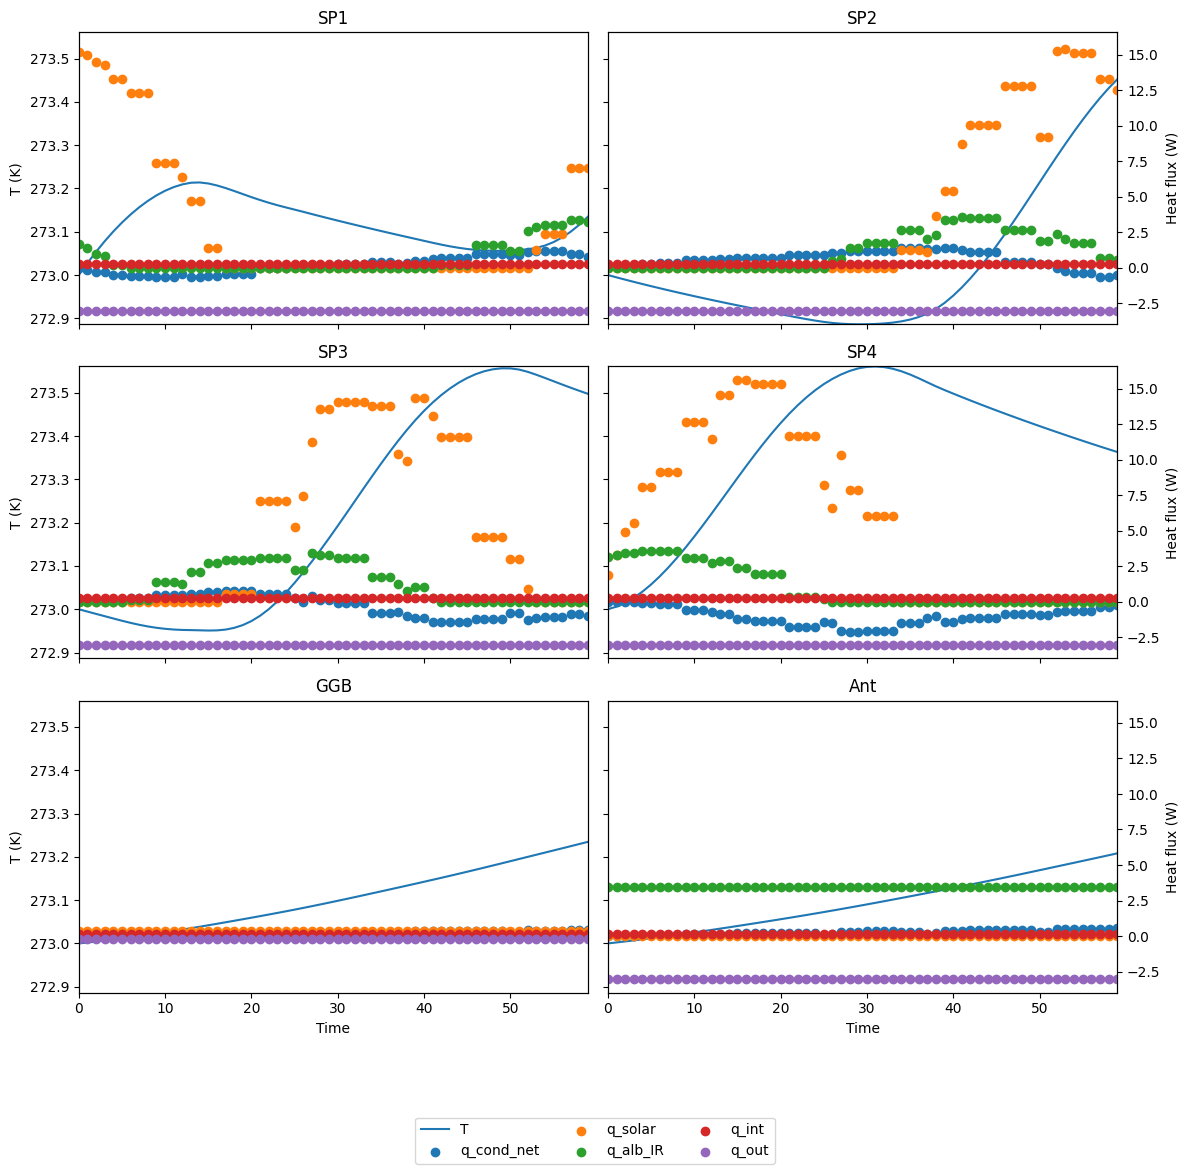

In [15]:
plotting.plot_elts_T_q_flows(sol.t, sol.y[12:, :], elts, elt_names=elt_names)

✓ For the long solar panel faces the solar radiation shows a rough sine wave, with one face being in the sun at a time. Meanwhile, the square faces see no sun at all, though the antenna face gets some radiation from the Earth. This makes sense for `R0=np.eye(3)` and `omega0=np.array([0,0,np.radians(5)])` i.e. the sat's long axis is aligned with Earth's spin axis, and probably at this time the sat just happened to be over the northern hemisphere so that the antenna face was facing at the Earth. \
✓ From the sun exposure of the solar panels, we see the sat almost went through one full rotation about its long axis in 1 minute, which makes sense for a spin of 5 deg/s (one rotation in 72 sec).\
✓ We also see that the temperature of each solar panel face increases with a bit of lag after sun exposure.\
✓ Net conductive heat flow goes negative when one face's temperature rises due to sun exposure, as heat is equalizing and flowing away into the cooler mass.\
✓ The GGB face has much lower radiative losses because it's entirely shiny metal with much lower emissivity than the FR4 of the antenna or the solar cell silicon.



Let's overlay the temperatures of all the lumped masses on one time axis:

<Axes: xlabel='Time', ylabel='T (K)'>

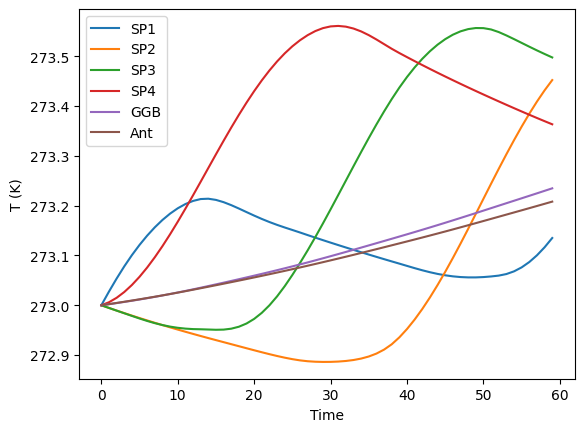

In [14]:
plotting.plot_elts_Ts(sol.t, sol.y[12:,:], elt_names=elt_names)

We see that the temperature of each solar panel face generally falls while it's in the shade, but as a whole the temperature of the sat rises.

Now, let's do one longer propagation for 10 orbits with a slowly tumbling sat (random starting orientation, random angular velocity with magnitude 0.1 deg/sec).

In [54]:
elts, body, orbit = init_blast_model(
    'excerpt_de440.bsp', omega_mag=np.radians(0.1),
)

In [55]:
sol = propagate_thermal_fem(
    elts, body, orbit,
    pd.Timestamp.now(tz='UTC'), pd.Timedelta(minutes=90*10), pd.Timedelta(seconds=10)
)

(<Figure size 1200x1200 with 12 Axes>,
 array([[<Axes: title={'center': 'SP1'}, ylabel='T (K)'>,
         <Axes: title={'center': 'SP2'}>],
        [<Axes: title={'center': 'SP3'}, ylabel='T (K)'>,
         <Axes: title={'center': 'SP4'}>],
        [<Axes: title={'center': 'GGB'}, xlabel='Time (orbital periods)', ylabel='T (K)'>,
         <Axes: title={'center': 'Ant'}, xlabel='Time (orbital periods)'>]],
       dtype=object))

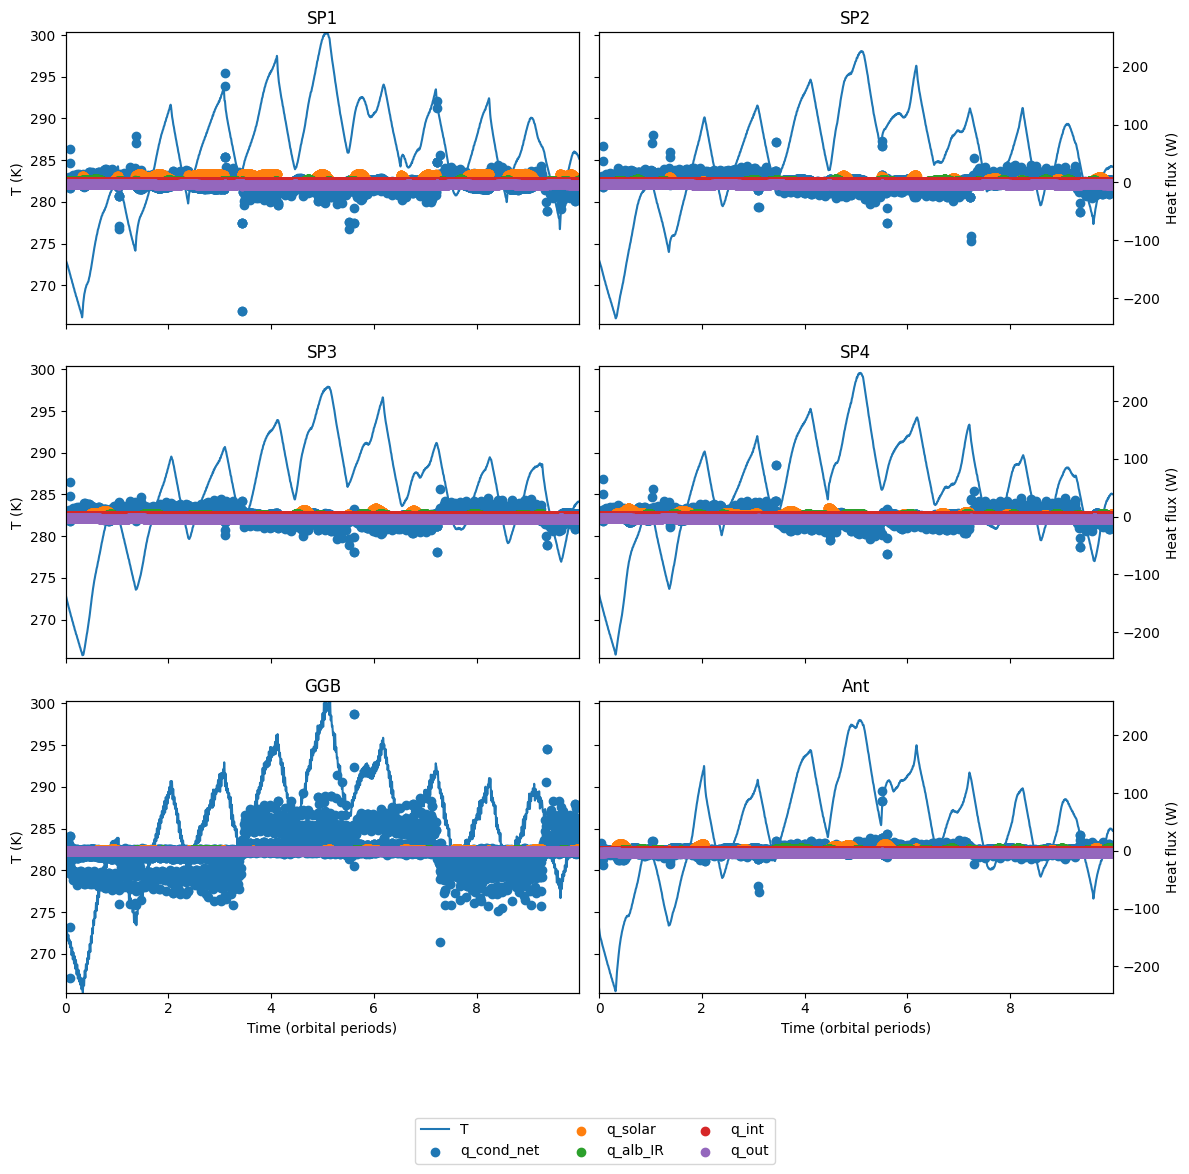

In [60]:
plotting.plot_elts_T_q_flows(sol.t, sol.y[12:, :], elts, elt_names=elt_names, orbital_period=90*60)

**TODO** - And here you see a bug in my code. While the temperatures in these plots look reasonable, the conductance heat fluxes of 100s of watts certainly do not. The problem is that the numerical integrator outputs temperatures after it has done its magic involving testing several time steps and smoothing between them. Meanwhile, heat fluxes are simply cached on the lumped masses at each evaluation by the numerical integrator, and so do not have this smoothing. 

Other than that, the plots look quite reasonable. The temperatures go up and down as the sat leaves and enters Earth's shadow, once every orbital period. The temperatures for the GGB are noticeably less smooth than for the other lumped masses, because, although the GGB face with its tip mass is considerably more massive than the other lumped masses, the specific heat capacity of lead is much lower than that of aluminum, so the GGB lumped mass is actually a much smaller thermal mass than the other lumped masses and sees more extreme variations in temperature.

Final sanity check that the temperatures of the different lumped masses vary only by a few degrees between each other at any one time:

<Axes: xlabel='Time (orbital periods)', ylabel='T (K)'>

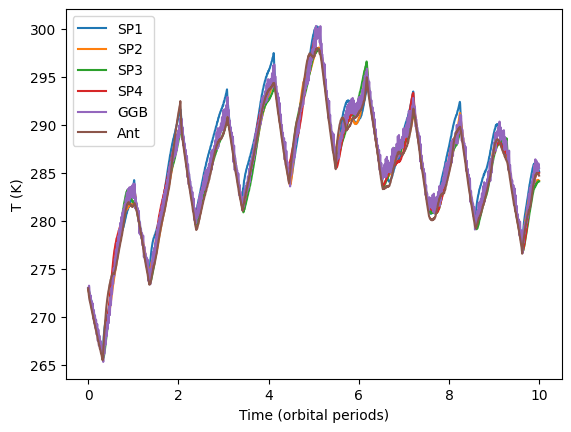

In [63]:
plotting.plot_elts_Ts(sol.t, sol.y[12:,:], orbital_period=90*60, elt_names=elt_names)